In [27]:
import edward as ed
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import scipy.stats

from edward.models import Normal

$x_1 \sim \mathcal{N}(x_1; 1, 1)$ <br>
$x_2 \sim \mathcal{N}(x_2; 2, 2)$

In [28]:
x1 = Normal(loc=tf.ones(1), scale=tf.ones(1))
x2 = Normal(loc=tf.ones(1)*2, scale=tf.ones(1)*2)

In [29]:
sess = ed.get_session()

In [30]:
sess.run(x1)

array([2.5523179], dtype=float32)

In [31]:
samples1 = []
for i in range(1000):
    samples1.append(sess.run(x1))
samples1 = np.vstack(samples1)

samples2 = []
for i in range(1000):
    samples2.append(sess.run(x2))
samples2 = np.vstack(samples2)

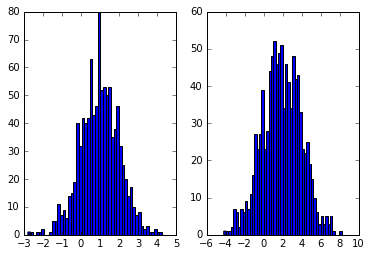

In [32]:
plt.subplot(1, 2, 1)
plt.hist(samples1, 50)
plt.subplot(1, 2, 2)
plt.hist(samples2, 50)
plt.show()

In [33]:
print(sess.run([x1.mean(), x1.variance()]))
print(sess.run([x2.mean(), x2.variance()]))

[array([1.], dtype=float32), array([1.], dtype=float32)]
[array([2.], dtype=float32), array([4.], dtype=float32)]


In [34]:
x3 = x1+x2

In [35]:
type(x3)

tensorflow.python.framework.ops.Tensor

In [36]:
samples3 = []
for i in range(1000):
    samples3.append(sess.run(x3))
samples3 = np.vstack(samples3)


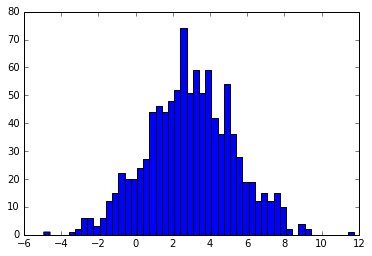

In [37]:
plt.hist(samples3, 50)
plt.show()

In [38]:
print(samples3.mean())
print(samples3.var())

2.944329
5.4965467


# Bayesian linear regression

$p(w)=\mathcal{N}(w;\mu,\sigma)$ <br>
$p(y|w, x)=\mathcal{N}(y;wx,\sigma_y)$


Input $x$ is a deterministic variable.
Variables $\mu$, $\sigma$ and $\sigma_w$ are known. <br>
Let us say: $\mu=0$, $\sigma=1$, and $\sigma_w=1$.

In [39]:
x_tf = tf.placeholder(tf.float32, (3, 1))
w_tf = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y_tf = Normal(loc=w_tf*x_tf, scale=tf.ones(1))

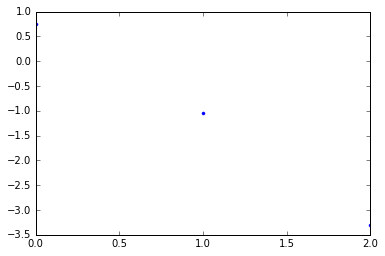

In [40]:
w = np.random.randn(1)
x = np.arange(3)
y = w*x + np.random.randn(*x.shape)
plt.plot(x, y, '.')
plt.show()

In [41]:
print(w)

[-0.71644182]


How $w$ is distributed given a datapoint $(x,y)$?

$p(w|x,y)=\frac{p(y, w; x)}{p(y; x)}=\frac{p(y|w;x)p(w)}{\int p(y|w ;x)p(w))dw}$

In [42]:
w_dom = np.linspace(-3, 3, 100)
w_joint = scipy.stats.norm.pdf(y[2], loc=w_dom*x[2], scale=1)*scipy.stats.norm.pdf(w_dom, loc=0, scale=1)

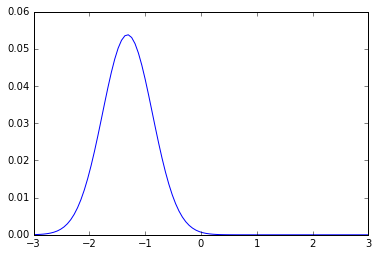

In [43]:
plt.plot(w_dom, w_joint)
plt.show()

Dataset is defined as
$\mathcal{D}=\{(x_i, y_i)\}_{i=1:N}$.

$p(y, \mathcal{D}, w)=p(w)\prod_{i=1}^N p(y_i|x_i;w)$

In [44]:
w_dom = w_dom[None, :]
x = x[:, None]
y = y[:, None]

In [45]:
joint_data = np.prod(scipy.stats.norm.pdf(y, loc=w_dom*x, scale=1), axis=0)*scipy.stats.norm.pdf(w_dom, loc=0, scale=1)

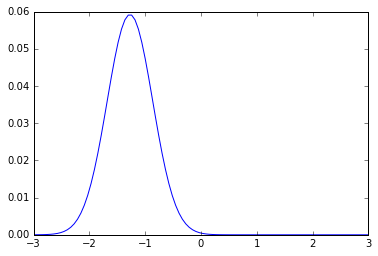

In [46]:
appr_post = joint_data/joint_data.sum()
plt.plot(w_dom[0], appr_post[0])
plt.show()

In [47]:
m = tf.Variable(np.float32([2.0]))
s = tf.Variable(np.float32([1.0]))
qw = Normal(loc=m, scale=tf.nn.softplus(s))

In [48]:
inference = ed.KLqp({w_tf: qw}, data={x_tf : x, y_tf : y})

In [49]:
inference.run(n_samples=10, n_iter=100)

100/100 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 4.716


In [50]:
print sess.run(s)

[-0.6819384]


In [51]:
print sess.run(m)

[-1.2205653]


(1, 100)


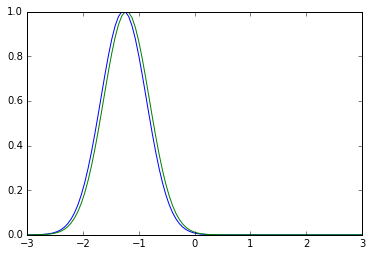

In [63]:
variational_pdf = scipy.stats.norm.pdf(w_dom, loc=sess.run(m)[0], scale=np.log(1.0+np.exp(sess.run(s)))[0])

variational_pdf/=np.max(variational_pdf)
appr_post/=np.max(appr_post)

print variational_pdf.shape
plt.plot(w_dom[0], appr_post[0], w_dom[0], variational_pdf[0])
plt.show()

In [56]:
sess.run(m)[0]

-1.2205653

# How variational approximation algorithm works?

The core idea involves two steps
- posit a family of distributions over latent variable $w$: $q(w;\lambda)$, where $\lambda$ a set of parameters of the distribution,
- match $q(w;\lambda)$ to the posterior by optimizing over its parameters $\lambda$.

In our example we choose the normal distribution
$q(w;\lambda)=\mathcal{N}(w;\mu_w,\sigma_w)$ <br> ($\lambda=\{\mu_w,\sigma_w\})$

$\lambda^*=\arg\underset{\lambda}{\min}KL(p(w|x,y)|q(w;\lambda))$

$\mu_w,\sigma_w=\arg\underset{\mu_w,\sigma_w}{\min}KL\left(\mathcal{N}(w,\mu_w,\sigma_w)\|p(w|x,y)\right)$

$\log p(x, y)=KL\left(\mathcal{N}(w;\mu_w,\sigma_w\|p(w|x, y))\right)+\mathbb{E}_{\mathcal{N}(w;\mu,\sigma)}\left[\log p(w, x, y)- \log \mathcal{N}(w;\mu, \sigma)\right]$ 

$\text{ELBO}(\mu_w,\sigma_w)=\mathbb{E}_{\mathcal{N}(w; \mu, \sigma)}\left[\log p(x, y, w) -\log\mathcal{N}(w;\mu_w,\sigma_w)\right]$

## Reparametrization gradient

$w\sim\mu_w+\sigma_w\mathcal{N}(0, 1)$

$\epsilon\sim q(\epsilon)$ <br>
$w=w(\epsilon;\mu_w,\sigma_w)$

$\nabla ELBO(\mu_w,\sigma_w)=\mathbb{E}_{q(\epsilon)}\left[\nabla_{\mu,\sigma}(\log p(x, y, w(\epsilon, \mu, \sigma))-\log q(w(\epsilon;\mu,\sigma);\mu,\sigma)\right]$

$\nabla ELBO(\mu,\sigma)\approx\frac{1}{S}\sum_{s=1}^S\left[\nabla_{\mu,\sigma}(\log p(x,y,w(\epsilon_s;\mu,\sigma))-\log q(w(\epsilon_s;\mu,\sigma);\mu,\sigma)\right]$